# Numerical differentiation by finite diferences

Our goal is to explore the dependence of the numerical error on the size of perturbation of the independent variable in [finite difference (FD)](https://en.wikipedia.org/wiki/Numerical_differentiation#Finite_differences) numerical differentiation scheme.

As an example, consider a scalar function of a vector argument $f(\mathbf x) = \sum_{i=1}^n x_i^2$

In [1]:
f(x) = sum(xᵢ^2 for xᵢ in x) 

f (generic function with 1 method)

Let's set some random vector $\mathbf x\in\mathbb R^n$. First, we pick the dimension `n`

In [2]:
j = 1
n = 10^j

10

In [3]:
x₀ = rand(n)

10-element Array{Float64,1}:
 0.8566789188220891
 0.5816498901094684
 0.6358555521874019
 0.030924335530379432
 0.9254341191018551
 0.10640604323138736
 0.9965536786537663
 0.6642923827516156
 0.1271063358389557
 0.6479414279483935

The function `f` evaluated at `x0` is

In [4]:
f(x₀)

4.215622236110449

Now, in order to compute the gradient $\nabla f$, we need to compute all the individual partial derivatives, the individual components of the vector. Let's now restrict ourselves just to one component, say, the first one, that is, let's compute $\frac{\partial f(\mathbf x)}{\partial x_1}$. In this simple example a formula can be written down upon inspection: $\frac{\partial f(\mathbf x)}{\partial x_1} = 2x_i$), but let's pretend that this answer is not available to us or we opt not to use it.

For reference, we compute the first component of the gradient using the "exact" formula above

In [5]:
dfdx_1_exact = 2*x₀[1]

1.7133578376441783

Let's now proceed to the numerical computation of this derivative.

## Numerical computation using quotients (finite differences)

The perturbation $h$ of the first compoment of the vector $x$ is

In [6]:
k = 3
h = 10.0^(-k)

0.001

Below we define a function for computing the first entry in the gradient (vector). Note that in defining the function we exploit the [multiple dispatch functionality of Julia](https://docs.julialang.org/en/v1/manual/methods/), thanks to which the function will compute with the floating point model of its input. That is, the input vector could be [IEEE-754 double-precision floating-point](https://en.wikipedia.org/wiki/Double-precision_floating-point_format) format, [IEEE-754 single-precision floating-point](https://en.wikipedia.org/wiki/Single-precision_floating-point_format) format (or perhaps even something else). 

In [7]:
function dfdx_1(f,x₀::Vector{T},h::T) where T<:Real
    x = copy(x₀)
    x[1] = x[1]+h
    (f(x)-f(x₀))/h
end

dfdx_1 (generic function with 1 method)

Let's compute the answer for the vector given (converted) into *IEEE single* format.

In [8]:
dfdx_1(f,Vector{Float32}(x₀),Float32(h))

1.7147063f0

Now, let's repeat the computation with the data in the *IEEE double* format (default for Julia)

In [9]:
dfdx_1(f,x₀,h)

1.71435783764462

Obviously, both answers differ from the correct one computed above 

In [10]:
dfdx_1_exact

1.7133578376441783

### Dependence of the error on the length of the step

Now, let's examine the error as a function of the size of the interval $h$

In [11]:
h_range = exp10.(range(-13, stop=-1, length=1000));

In [12]:
abs_er_64 = [abs((dfdx_1_exact - dfdx_1(f,x₀,h))) for h in h_range];
abs_er_32 = [abs((dfdx_1_exact - dfdx_1(f,Vector{Float32}(x₀),Float32(h)))) for h in h_range];

In [13]:
using Plots
gr()

Plots.GRBackend()

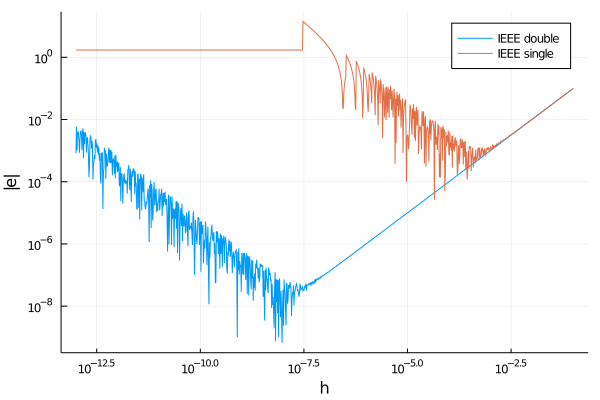

In [14]:
plot(h_range, abs_er_64,xaxis=:log, yaxis=:log, xlabel="h", ylabel = "|e|", label = "IEEE double")
plot!(h_range, abs_er_32,xaxis=:log, yaxis=:log, xlabel="h", ylabel = "|e|", label = "IEEE single")

If we read the graph from right to left – as $h$ is getting smaller –, we observe that initially the error decreases for both 64- and 32-bit floating-point format, and it decreases at the same rate. The reason for this decrease is that the trunction error dominates here, and this error goes down with $h$.

The major intended takeaway from this example is that this reduction of the error only takes place down to some $h$ below which no longer decreases; in fact, it actally increases as $h$ gets smaller. The reason is that for $h$ this small, the rounding errors dominate. Apparently, they start exhibitting themselves for smaller values with the 64-bit format than with 32-bit format.  

It is known from rigorous numerical analysis that the error in the case of the simple backward or forward finite difference approximation to a scalar derivative scales with $\sqrt{\epsilon}$, where $\epsilon$ is the [machine epsilon](https://en.wikipedia.org/wiki/Machine_epsilon). Here we can expect even worse outcome as the dimension $n$ of the vector grows.  

Note that $\epsilon$ for double precision IEEE is

In [15]:
2^(-53)

1.1102230246251565e-16

which is available in Julia through [eps()](https://docs.julialang.org/en/v1/manual/integers-and-floating-point-numbers/#Machine-epsilon) function with the type as the input argument (if no argument is given, it assumes `Float64`):

In [16]:
sqrt(eps())

1.4901161193847656e-8

Similarly, the 32-bit version is

In [17]:
sqrt(eps(Float32))

0.00034526698f0

Apparently, these are roughly the "cutt-off" values of $h$.